# SASRec & SSEPT

### Sequential Recommendation Using Transformer \[1, 6\] 

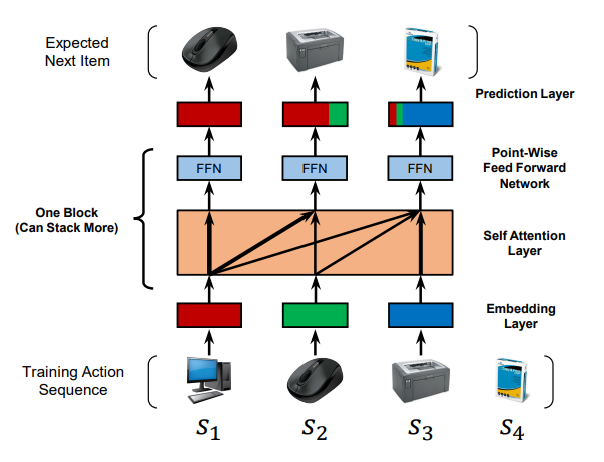

This is a class of sequential recommendation that uses Transformer \[2\] for encoding the users preference represented in terms of a sequence of items purchased/viewed before. Instead of using CNN (Caser \[3\]) or RNN (GRU \[4\], SLI-Rec \[5\] etc.) the approach relies on Transformer based encoder that generates a new representation of the item sequence. Two variants of this Transformer based approaches are included here, 

- Self-Attentive Sequential Recommendation (or SASRec [1]) that is based on vanilla Transformer and models only the item sequence and
- Stochastic Shared Embedding based Personalized Transformer or SSE-PT [6], that also models the users along with the items. 

This notebook provides an example of necessary steps to train and test either a SASRec or a SSE-PT model. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pandas as pd 
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # only show error messages

from recommenders.datasets.amazon_reviews import get_review_data
from recommenders.datasets.split_utils import filter_k_core
from recommenders.models.sasrec.model import SASREC
from recommenders.models.sasrec.ssept import SSEPT
from recommenders.models.sasrec.sampler import WarpSampler
from recommenders.models.sasrec.util import SASRecDataSet
from recommenders.utils.notebook_utils import store_metadata
from recommenders.utils.timer import Timer


print(f"System version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")

2022-03-22 10:24:04.916252: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/:/opt/gurobi902/linux64/lib:/opt/gurobi902/linux64/lib
2022-03-22 10:24:04.916292: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


System version: 3.7.11 (default, Jul 27 2021, 14:32:16) 
[GCC 7.5.0]
Tensorflow version: 2.8.0


### Input Parameters

In [3]:
num_epochs = 5
batch_size = 128
seed = 100  # Set None for non-deterministic result

# data_dir = os.path.join("tests", "recsys_data", "RecSys", "SASRec-tf2", "data")
data_dir = os.path.join("..", "..", "tests", "resources", "deeprec", "sasrec")

# Amazon Electronics Data
dataset = "reviews_Electronics_5"

lr = 0.001             # learning rate
maxlen = 50            # maximum sequence length for each user
num_blocks = 2         # number of transformer blocks
hidden_units = 100     # number of units in the attention calculation
num_heads = 1          # number of attention heads
dropout_rate = 0.1     # dropout rate
l2_emb = 0.0           # L2 regularization coefficient
num_neg_test = 100     # number of negative examples per positive example
model_name = 'ssept'  # 'sasrec' or 'ssept'

In [4]:
reviews_name = dataset + '.json'
outfile = dataset + '.txt'

reviews_file = os.path.join(data_dir, reviews_name)
if not os.path.exists(reviews_file):
    reviews_output = get_review_data(reviews_file)
else:
    reviews_output = os.path.join(data_dir, dataset+".json_output")

In [16]:
if not os.path.exists(os.path.join(data_dir, outfile)):
    df = pd.read_csv(reviews_output, sep="\t", names=["userID", "itemID", "time"])
    df = filter_k_core(df, 10)  # filter for users & items with less than 10 interactions
    
    user_set, item_set = set(df['userID'].unique()), set(df['itemID'].unique())
    user_map = dict()
    item_map = dict()
    for u, user in enumerate(user_set):
        user_map[user] = u+1
    for i, item in enumerate(item_set):
        item_map[item] = i+1
    
    df["userID"] = df["userID"].apply(lambda x: user_map[x])
    df["itemID"] = df["itemID"].apply(lambda x: item_map[x])
    df = df.sort_values(by=["userID", "time"])
    df.drop(columns=["time"], inplace=True)
    df.to_csv(os.path.join(data_dir, outfile), sep="\t", header=False, index=False)

Original: 192403 users and 63001 items
Final: 20247 users and 11589 items


SASRec requires sequence input and sequence target. Targets are for both positive and negative examples. Inputs to the model are 

* user's item history as input to the transformer
* user's item history shifted (by 1) as target to the transformer (positive examples)
* a sequence of items that are not equal to the positive examples (negative examples)

From each user's history three samples are created. If there are $N_u$ items for user-$u$ then $N_u-2$ items are used in training and the last two items are used for validation and testing, respectively. 

## Dataset Format 

- The input files should have the following format:
    - each row has user-id and item-id converted into integers (starting from 1)
    - the rows are sorted by user-id and time of interaction
    - for every user the last item is used for testing and the last but one is used for validation
    - for example, for user `30449` the sorted inputs are:
        - `30449 2771`
        - `30449 61842`
        - `30449 60293`
        - `30449 30047`
        - `30449 63296`
        - `30449 22042`
        - `30449 6717`
        - `30449 75780`
      
      then the train inputs are 
        - [`2771`, `61842`, `60293`, `30047`, `63296`] (input sequence)
        - [`61842`, `60293`, `30047`, `63296`, `22042`] (target sequence for positive examples)
        - [`1001`, `50490`, `33312`, `19294`, `45342`] (sample negative examples)

      and the validation inputs are 
        - [`2771`, `61842`, `60293`, `30047`, `63296`, `22042`] (input sequence)
        - [`61842`, `60293`, `30047`, `63296`, `22042`, `6717`] (target sequence for positive examples)
        - [`4401`, `60351`, `22176`, `23456`, `45342`, '1193`] (sample negative examples)
        
      and the test inputs are 
        - [`2771`, `61842`, `60293`, `30047`, `63296`, `22042`, `6717`] (input sequence)
        - [`61842`, `60293`, `30047`, `63296`, `22042`, `6717`, `75780`] (target sequence for positive examples)
        - [`4401`, `60351`, `22176`, `23456`, `45342`, '1193`, `54231`] (sample negative examples)
    

In [7]:
inp_file = os.path.join(data_dir, dataset + ".txt")
print(inp_file)

# initiate a dataset class 
data = SASRecDataSet(filename=inp_file, col_sep="\t")

# create train, validation and test splits
data.split()

# some statistics
num_steps = int(len(data.user_train) / batch_size)
cc = 0.0
for u in data.user_train:
    cc += len(data.user_train[u])
print('%g Users and %g items' % (data.usernum, data.itemnum))
print('average sequence length: %.2f' % (cc / len(data.user_train)))

../../tests/resources/deeprec/sasrec/reviews_Electronics_5.txt
20247 Users and 11589 items
average sequence length: 15.16


### Model Creation

Model parameters are

    - number of items
    - maximum sequence length of the user interaction history
    - number of Transformer blocks
    - embedding dimension for item embedding
    - dimension of the attention
    - number of attention heads
    - dropout rate
    - dimension of the convolution layers, list
    - L_2-regularization coefficient

In [ ]:
if model_name == 'sasrec':
    model = SASREC(item_num=data.itemnum,
                   seq_max_len=maxlen,
                   num_blocks=num_blocks,
                   embedding_dim=hidden_units,
                   attention_dim=hidden_units,
                   attention_num_heads=num_heads,
                   dropout_rate=dropout_rate,
                   conv_dims = [100, 100],
                   l2_reg=l2_emb,
                   num_neg_test=num_neg_test
    )
elif model_name == "ssept":
    model = SSEPT(item_num=data.itemnum,
                  user_num=data.usernum,
                  seq_max_len=maxlen,
                  num_blocks=num_blocks,
                  # embedding_dim=hidden_units,  # optional
                  user_embedding_dim=10,
                  item_embedding_dim=hidden_units,
                  attention_dim=hidden_units,
                  attention_num_heads=num_heads,
                  dropout_rate=dropout_rate,
                  conv_dims = [110, 110],
                  l2_reg=l2_emb,
                  num_neg_test=num_neg_test
    )
else:
    print(f"Model-{model_name} not found")

### Sampler

    - the sampler creates negative samples from the training data for each batch
    - this is done by looking at the original user interaction history and creating items that are not present at all
    - the sampler generates a sequence of negative items of the same length as the original history

In [9]:
sampler = WarpSampler(data.user_train, data.usernum, data.itemnum, batch_size=batch_size, maxlen=maxlen, n_workers=3)

### Model Training

    - the loss function is defined over all the negative and positive logits
    - a mask has to be applied to indicate the non-zero items present in the output
    - we also add the regularization loss here
    
    - having a train-step signature function can speed up the training process

In [10]:
with Timer() as train_time:
    t_test = model.train(data, sampler, num_epochs=num_epochs, batch_size=batch_size, lr=lr, val_epoch=6)

print('Time cost for training is {0:.2f} mins'.format(train_time.interval/60.0))


epoch: 5, test (NDCG@10: 0.3099896446332482, HR@10: 0.5142)
Time cost for training is 7.17 mins


In [11]:
res_syn = {"ndcg@10": t_test[0], "Hit@10": t_test[1]}
print(res_syn)

{'ndcg@10': 0.3037326157112286, 'Hit@10': 0.5036}


In [19]:
# Record results for tests - ignore this cell
store_metadata("ndcg@10", t_test[0])
store_metadata("Hit@10", t_test[1])

## Reference
\[1\] Wang-Cheng Kang, Julian McAuley: Self-Attentive Sequential Recommendation, arXiv preprint arXiv:1808.09781 (2018) <br>

\[2\] Ashish Vaswani, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Łukasz Kaiser, and Illia Polosukhin. 2017. Attention is all you need. In Advances in Neural Information Processing Systems. 5998–6008 <br>

\[3\] Jiaxi Tang and Ke Wang. 2018. Personalized top-n sequential recommendation via convolutional sequence embedding. In Proceedings of the Eleventh ACM International Conference on Web Search and Data Mining. ACM, 565–573.

\[4\] Kyunghyun Cho, Bart van Merrienboer, Caglar Gulcehre, Dzmitry Bahdanau, Fethi Bougares, Holger Schwenk, and Yoshua Bengio. Learning Phrase Representations using RNN Encoder-Decoder for Statistical Machine Translation. arXiv preprint arXiv:1406.1078. 2014.

\[5\] Zeping Yu, Jianxun Lian, Ahmad Mahmoody, Gongshen Liu, Xing Xie. Adaptive User Modeling with Long and Short-Term Preferences for Personailzed Recommendation. In Proceedings of the 28th International Joint Conferences on Artificial Intelligence, IJCAI’19, Pages 4213-4219. AAAI Press, 2019.

\[6\] Liwei Wu, Shuqing Li, Cho-Jui Hsieh, James Sharpnack. SSE-PT: Sequential Recommendation Via Personalized Transformer. In Fourteenth ACM Conference on Recommender Systems, RecSys'20:, Pages 328–337, 2020.